In [48]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

from pathlib import Path
import numpy as np
import torch as th
from collections import defaultdict
from tqdm import tqdm
import json
from transcription import  evaluate
from transcription.core import decoding, MAESTRO, representation
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec

from mir_eval.transcription import match_notes
from scipy.stats import entropy
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
dataset = MAESTRO(path='/home/ilcobo2/transcription_exp/data/MAESTRO', meta_json='maestro-v1.0.0.json', groups=['test'])

Loading group test:   0%|          | 0/125 [00:00<?, ?it/s]

['test'] ['train', 'validation', 'test', 'debug']
Loading 1 group of MAESTRO at /home/ilcobo2/transcription_exp/data/MAESTRO


Loading group test: 100%|██████████| 125/125 [00:12<00:00, 10.24it/s]


In [45]:
target = '/home/ilcobo2/transcription_exp/results/onf'
n = 0

gt_label = dataset.data[n]['label']
pred_file = Path(dataset.data[n]['path'].split('/')[-1]).stem + '_pred.npz'

In [42]:
dataset.data[n]

{'path': 'data/MAESTRO/2004/MIDI-Unprocessed_SMF_16_R1_2004_01-08_ORIG_MID--AUDIO_16_R1_2004_02_Track02_wav.flac',
 'audio': tensor([111, 109, 107,  ..., -80, -81, -86], dtype=torch.int16),
 'label': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8),
 'velocity': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8),
 'time': 0}

In [70]:
pred = np.load(Path(target) / pred_file)
onset_prob = pred['arr_0']
offset_prob = pred['arr_1']
frame_prob = pred['arr_2']

pred_seq = decoding.magenta_decoding(onset_prob, frame_prob, offset_prob)
pred_roll = decoding.seq_to_pianoroll(pred_seq)

onset_label, offset_label, frame_label = representation.convert2onsets_and_frames(gt_label, rep_type='base')

In [71]:
cmap = plt.get_cmap('tab20c')
cmap.colors
my_cmap = colors.ListedColormap(['white', cmap.colors[0] , 'black'])
norm = colors.BoundaryNorm([0, 1, 2, 3], my_cmap.N, clip=True)
my_cmap2 =  colors.ListedColormap(['white', cmap.colors[0] , cmap.colors[9], cmap.colors[5]])
norm2 = colors.BoundaryNorm([0, 1, 2, 3, 4], my_cmap2.N, clip=True)

In [85]:
def diff(pred, label):
    binary_label = (label > 1)
    binary_pred = (pred >= 1)
    posit = np.logical_and(binary_pred, binary_label)
    fp = np.logical_and(binary_pred, np.logical_not(binary_label))
    fn = np.logical_and(np.logical_not(binary_pred), binary_label)
    assert(np.count_nonzero(posit * fp * fn) == 0)
    return posit + 2*fp + 3*fn

In [95]:
err = diff(pred_roll[:500, 8:60].T, gt_label[:500, 8:60].T).numpy()

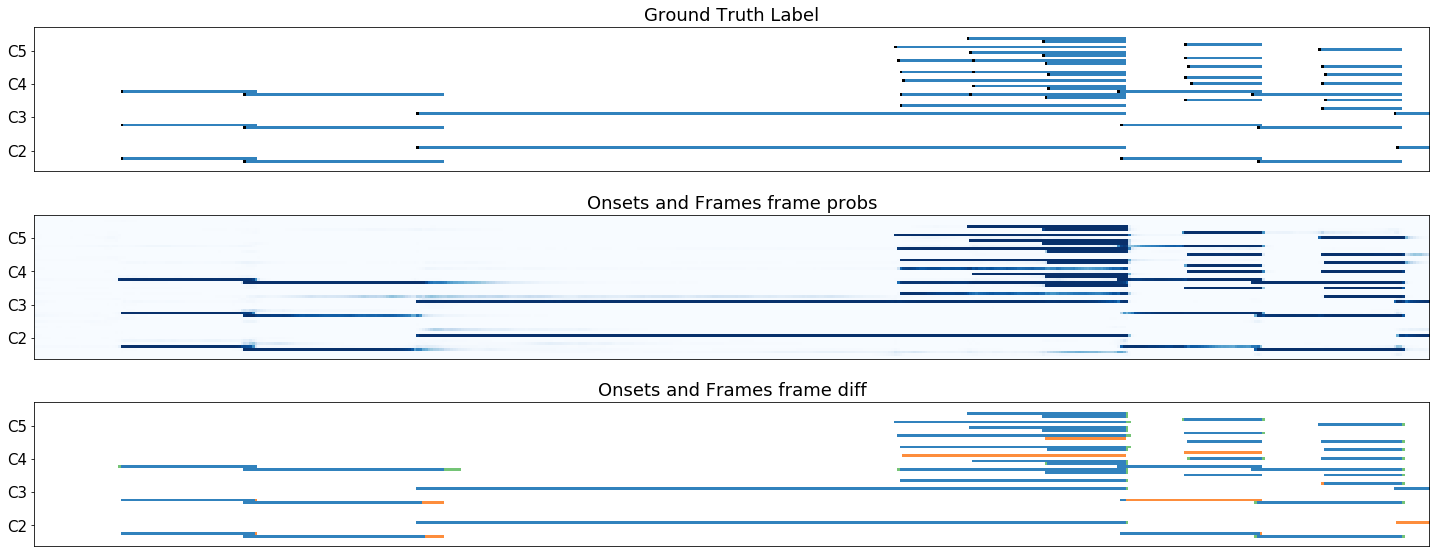

In [96]:
fig = plt.figure(figsize=(25,13))
gs = fig.add_gridspec(4,3, hspace=0.3)
gt_show = onset_label*2 + frame_label

font = {'size':15}
plt.rc('font', **font)

ax0 = fig.add_subplot(gs[0, :])
pcm0 = ax0.imshow(gt_show[:500, 8:60].T, aspect='auto', interpolation='nearest', origin='bottom', cmap=my_cmap, norm=norm)
ax0.set_title('Ground Truth Label')
ax1 = fig.add_subplot(gs[1, :])
pcm1 = ax1.imshow(frame_prob[:500, 8:60].T, aspect='auto', interpolation='nearest', origin='bottom', cmap='Blues')
ax1.set_title('Onsets and Frames frame probs')
ax2 = fig.add_subplot(gs[2, :])
pcm2 = ax2.imshow(err, aspect='auto', interpolation='nearest', origin='bottom', cmap=my_cmap2, norm=norm2)
ax2.set_title('Onsets and Frames frame diff')

for ax in [ax0, ax1, ax2]:
    ax.set_yticks(list(range(7, 52, 12)))
    ax.set_yticklabels(['C'+str(el) for el in range(2,6)])
    ax.set_xticks([])